# Outcome metric
Evaluating baselines

### Import libraries

In [1]:
import os, sys
from typing import List
from collections.abc import Callable

In [2]:
import pandas as pd
import numpy as np

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8.27
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [6]:
from ipywidgets import interact, interact_manual, FloatSlider

In [7]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, fetch_data, preprocess, create_dataset

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

### Fetch data

In [100]:
progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1],
                                       FILES[DATA_FOLDERS[1]]['progression']))

progression['study_phase'] = progression.study_name.apply(extract_study_phase)

In [25]:
labels = ['prediction_score', 'pseudorecist']

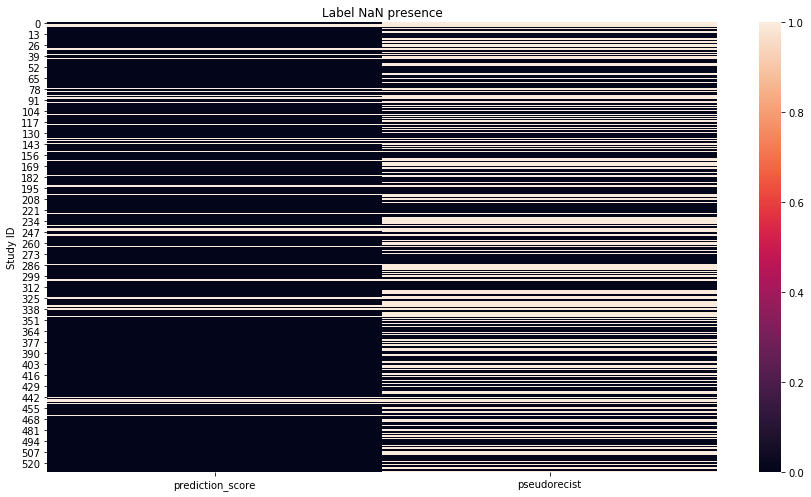

(None, None)

In [26]:
fig, ax = plt.subplots()

sns.heatmap(progression[labels].isna(), ax=ax)

ax.set_title('Label NaN presence')
ax.set_ylabel('Study ID')

plt.savefig('label-nan.png', dpi=200), plt.show()

In [28]:
counts = pd.DataFrame({feature: progression[feature].value_counts().append(
    pd.Series([progression[feature].isna().sum()], index=['NaN'])) for feature in labels})
counts

,prediction_score,pseudorecist
NPD,290,206
PD,183,91
NaN,58,234


In [32]:
both = progression[labels][(progression.pseudorecist.notna()) & (progression.prediction_score.notna())].shape[0]
only_pseudo = progression[labels][(progression.pseudorecist.notna()) & (progression.prediction_score.isna())].shape[0]
only_predic = progression[labels][(progression.pseudorecist.isna()) & (progression.prediction_score.notna())].shape[0]
none = progression[labels][(progression.pseudorecist.isna()) & (progression.prediction_score.isna())].shape[0]

print(f'Studies containing: \n'
      f'  Both: {both}\n'
      f'  Only pseudorecist: {only_pseudo}\n'
      f'  Only prediction score: {only_predic}\n'
      f'  None: {none}')

Studies containing: 
  Both: 297
  Only pseudorecist: 0
  Only prediction score: 176
  None: 58


In [98]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)
lesions = lesions[(lesions.pars_classification_petct != 'benign')]

In [46]:
def classify_response(row):
    # Compare current vs. baseline
    if row.tmtv < row.baseline:
        return 'NPD'
    elif row.tmtv == row.baseline:
        return np.nan
    else:
        return 'PD'

In [99]:
# Compute TMTV by summing `vol_ccm` per study
labels = lesions.groupby(['gpcr_id', 'study_phase']).vol_ccm.sum().to_frame('tmtv').reset_index()

# Find `labels` id of each patient's baseline TMTV
baseline_idx = labels.groupby('gpcr_id').study_phase.idxmin().to_dict()
labels['baseline'] = labels.gpcr_id.apply(lambda i: labels.loc[baseline_idx[i]].tmtv)
labels['response'] = labels.apply(classify_response, axis=1)

print(f'Response computed for {labels.shape[0]} studies: \n{labels.response.value_counts()}')

Response computed for 395 studies: 
PD     144
NPD    126
Name: response, dtype: int64


In [101]:
labels = progression.merge(labels, on=['gpcr_id', 'study_phase'], how='outer')

In [104]:
flabels = labels.loc[labels.groupby('gpcr_id').study_phase.idxmax()]

In [102]:
flabels = labels[labels.study_phase == 1]

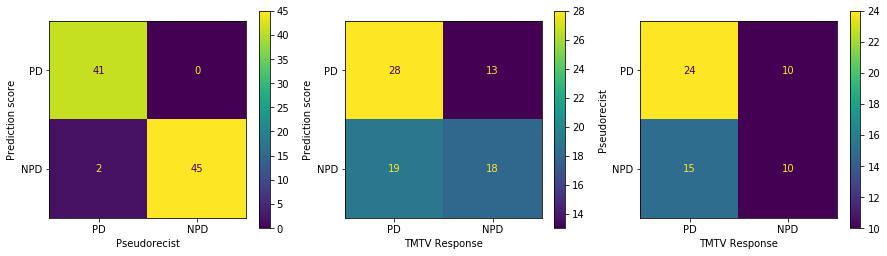

In [105]:
fig, ax = plt.subplots(1, 3)

cm = confusion_matrix(flabels[['prediction_score', 'pseudorecist']].dropna().prediction_score, 
                      flabels[['prediction_score', 'pseudorecist']].dropna().pseudorecist,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[0])

ax[0].set_xlabel('Pseudorecist'), ax[0].set_ylabel('Prediction score')


cm = confusion_matrix(flabels[['prediction_score', 'response']].dropna().prediction_score, 
                      flabels[['prediction_score', 'response']].dropna().response,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[1])

ax[1].set_xlabel('TMTV Response'), ax[1].set_ylabel('Prediction score')

cm = confusion_matrix(flabels[['pseudorecist', 'response']].dropna().pseudorecist, 
                      flabels[['pseudorecist', 'response']].dropna().response,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[2])

ax[2].set_xlabel('TMTV Response'), ax[2].set_ylabel('Pseudorecist')

plt.gcf().set_size_inches(15, 4)
plt.show()

In [33]:
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['patients']))

In [37]:
patients.columns

Index(['gpcr_id', 'age_at_treatment_start_in_years',
       'duration_treatment_in_days', 'death_event_observed',
       'survival_in_days', 'n_imgs_before_treatment',
       'n_imgs_during_treatment', 'n_imgs_after_treatment_end',
       'n_imgs_after_treatment_start'],
      dtype='object')

In [36]:
counts = pd.DataFrame({feature: patients[feature].value_counts().append(
    pd.Series([patients[feature].isna().sum()], index=['NaN'])) for feature in ['death_event_observed']})
counts

,death_event_observed
False,72
True,61
NaN,0


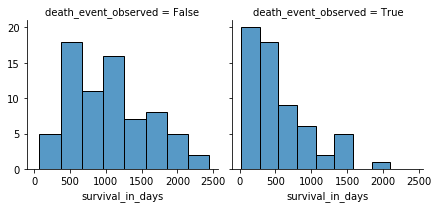

In [44]:
g = sns.FacetGrid(patients, col='death_event_observed')
g.map_dataframe(sns.histplot, 'survival_in_days')
g.add_legend()

In [107]:
blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES[DATA_FOLDERS[1]]['blood']))
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)
# Listify immunotherapy type to create multi-feature encoding
blood['immuno_therapy_type'] = blood.immuno_therapy_type \
    .apply(lambda t: ['ipi', 'nivo'] if t == 'ipinivo' else [t])

In [108]:
blood.columns

Index(['gpcr_id', 'n_days_to_treatment_start', 'n_days_to_treatment_end',
       'sex', 'bmi', 'has_brain_mets', 'performance_score_ecog',
       'asat_sang_ul', 'bili_totale_sang_umoll', 'mono_absolus_gl',
       'alat_sang_ul', 'plaquettes_sang_gl', 'lympho_absolus_gl',
       'albumine_sang_gl', 'proteine_c_reacsang_mgl', 'potassium_sang_mmoll',
       'hemoglobine_sang_gl', 'calcium_sang_mmoll', 'ldh_sang_ul',
       'creatinine_sang_umoll', 'pal_sang_ul', 'neutro_absolus_gl',
       'eosini_absolus_gl', 'baso_absolus_gl', 'ggt_sang_ul',
       'gfr_cal_mlmin173m2', 'leucocytes_sang_gl', 'eGFRCKD2', 'eGFRCG', 'X67',
       'NRAS_MUTATION', 'NRAS_MUT_TYPE', 'BRAF_MUTATION', 'BRAF_MUT_TYPE',
       'concomittant_tvec', 'concomittant_LAG3', 'prior_targeted_therapy',
       'prior_treatment', 'immuno_therapy_type', 'nivo_maintenance'],
      dtype='object')

In [118]:
@interact(feature=list(blood.columns))
def show_distribution(feature: str):
    sns.displot(blood, x=feature)
    plt.show()

interactive(children=(Dropdown(description='feature', options=('gpcr_id', 'n_days_to_treatment_start', 'n_days…

In [136]:
all(blood.leucocytes_sang_gl.value_counts().keys() == [0, 1])

False

In [125]:
blood['nivo_maintenance'] = blood.nivo_maintenance.astype(bool)

In [129]:
list(blood.select_dtypes([bool, object]).columns)

['sex',
 'has_brain_mets',
 'NRAS_MUTATION',
 'NRAS_MUT_TYPE',
 'BRAF_MUTATION',
 'BRAF_MUT_TYPE',
 'immuno_therapy_type',
 'nivo_maintenance']

In [128]:
[*blood.select_dtypes(object).columns]

['sex',
 'has_brain_mets',
 'NRAS_MUTATION',
 'NRAS_MUT_TYPE',
 'BRAF_MUTATION',
 'BRAF_MUT_TYPE',
 'immuno_therapy_type']